In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


In [2]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


In [3]:
display(rating.describe())

,userId,productId,rating
count,7.202839e+06,7.202921e+06,7.202920e+06
mean,3.368837e+05,2.651382e+05,4.277313e+00
std,3.619076e+05,1.525959e+05,1.060728e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331870e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965950e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


In [4]:
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [5]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

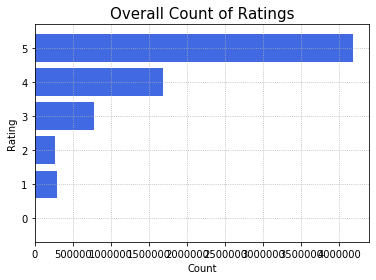

,rating,Count
0,0.0,1
1,1.0,293748
2,2.0,261960
3,3.0,781982
4,4.0,1680574


In [6]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()
display(ratingViaUserCount.head())

In [7]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 50 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 100 ].index)]
print(ratingFiltered.shape)

(1847803, 3)
(7202921, 3)
(35024, 3)


In [8]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratingFiltered[['userId', 'productId', 'rating']], reader)

In [9]:
display(products.sample(10))
display(ratingFiltered.sample(10))
display(ratingFiltered.shape)

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
64288,男人四十在忙碌中释放自己,"832,151,305",832,图书音像,151,经管类图书,305.0,成功/励志
290818,巨人恰恰传奇,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
330878,当历史可以观看,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
255464,PNY 必恩威 白色 多功能手机宝贝 4GB,"1057,268,378",1057,电脑/办公,268,存储设备,378.0,U盘
73485,优1宝贝男童羊毛开衫灰色 Z0513003 90,"802,777,914",802,服饰服装,777,童装/童鞋/亲子装,914.0,儿童上装
197430,"高露洁360卓效多护漱口水500ML(特卖)(新老包装更替,随机发货)","916,1009,1108",916,美妆个护,1009,口腔护理,1108.0,漱口水
317700,老子的智慧(图文版),"832,723,396",832,图书音像,723,人文社科类图书,396.0,哲学/宗教
339831,明清间耶稣会士译著提要,"832,723,396",832,图书音像,723,人文社科类图书,396.0,哲学/宗教
247083,蒲蒲兰绘本馆:小老鼠的漫长一夜,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


,userId,productId,rating
4738191,39977.0,249013,5.0
4680284,5693.0,244195,4.0
785859,684.0,377461,5.0
6724732,25999.0,406472,5.0
5583682,140344.0,467206,5.0
5756901,12301.0,193282,5.0
5927343,65078.0,134844,1.0
3608283,693.0,512606,1.0
6744142,10980.0,407467,1.0
499909,3204.0,44018,5.0


(35024, 3)

In [10]:
print('No. of Unique Users    :', ratingFiltered.userId.nunique())
print('No. of Unique Products :', ratingFiltered.productId.nunique())
print('No. of Unique Ratings  :', ratingFiltered.rating.nunique())
print(products.iloc[1].product_name)

No. of Unique Users    : 241
No. of Unique Products : 22683
No. of Unique Ratings  : 5
Treasure Island


In [11]:
productJoinEdRaiting = pd.merge(products, ratingFiltered, on='productId', how='inner')

In [14]:
display(productJoinEdRaiting.sample(10))

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
2983,42872,易经杂说,"832,723,221",832,图书音像,723,人文社科类图书,221.0,政治/军事,5729.0,4.0
20030,307599,华图????江西省公务员录用考试专用教材:行政职业能力测验(2012最新版),"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,47.0,5.0
6406,96443,杨红樱画本????科学童话系列:背着房子的蜗牛,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,88899.0,5.0
7486,112463,"DANYIN 硕美科/电音DT-315(白色)头戴式耳麦,时尚菱形耳壳,线控音量调节。","1057,439,992",1057,电脑/办公,439,外设产品,992.0,耳机/耳麦,20660.0,5.0
13712,208895,界面设计模式(影印版)(第2版),"832,1096,43",832,图书音像,1096,科技类图书,43.0,计算机/网络,75140.0,5.0
31277,470593,刺猬的优雅,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,1411.0,2.0
20684,319094,"SanDisk闪迪????CZ538G酷型USB闪存盘喷漆图案,超薄、隐藏接口设计","1057,268,378",1057,电脑/办公,268,存储设备,378.0,U盘,30058.0,3.0
29373,443797,Panasonic松下电吹风EH-ND20-W,"222,621,521",222,家用电器,621,个人护理电器,521.0,电吹风,2097.0,5.0
32404,486837,JCODE静佳五维空间化妆棉100*5片居家装相当于500片,"916,416,243",916,美妆个护,416,彩妆,243.0,美妆工具,15596.0,4.0
3207,45832,妙洁平底垃圾袋(M)中号(45CM*50CM)30只买2送1 (2组180只装),"933,714,858",933,家居生活,714,家庭清洁,858.0,垃圾袋,858.0,4.0


In [52]:
ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' , inplace =True )
ratingFilteredPivot = ratingFiltered.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

In [46]:
#user based:
raitingFilteredMatrix = csr_matrix(ratingFilteredPivot.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(raitingFilteredMatrix)
NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine', metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

#489000->productId
queryIndex = raitingFilteredPivot.index.get_loc(231449)
# queryIndex = np.random.choice(raitingFilteredPivot.shape[0])
distances, indices = model_knn.kneighbors(raitingFilteredPivot.iloc[queryIndex, :].values.reshape(1, -1), n_neighbors=6)

print('Recommendations for {0} ( {1} | {2} | {3} :\n'.format( products.iloc[raitingFilteredPivot.index[queryIndex]].product_name ,
                                                                     products.iloc[raitingFilteredPivot.index[queryIndex]].cat1_name,
                                                                     products.iloc[raitingFilteredPivot.index[queryIndex]].cat2_name,
                                                                     products.iloc[raitingFilteredPivot.index[queryIndex]].cat3_name))

for i in range(0, len(distances.flatten())):
        print('{0}: {1} ( {2} | {3} | {4} ) , with distance of {5}:'.format(i,
                                                                           products.iloc[raitingFilteredPivot.index[indices.flatten()[i]]].product_name ,
                                                                           products.iloc[raitingFilteredPivot.index[indices.flatten()[i]]].cat1_name,
                                                                           products.iloc[raitingFilteredPivot.index[indices.flatten()[i]]].cat2_name,
                                                                           products.iloc[raitingFilteredPivot.index[indices.flatten()[i]]].cat3_name,
                                                                           distances.flatten()[i]))

In [48]:
productJoinEdRaiting[productJoinEdRaiting.userId == 5729 ]

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
41,575,山居笔记,"832,723,221",832,图书音像,723,人文社科类图书,221.0,政治/军事,5729.0,5.0
94,1347,FLYCO飞科电吹风FH6217(小功率 1000W功率 可折叠式 冷/热风 健康柔风护发 ...,"222,621,521",222,家用电器,621,个人护理电器,521.0,电吹风,5729.0,5.0
111,1659,不疲劳的生活,"832,151,305",832,图书音像,151,经管类图书,305.0,成功/励志,5729.0,5.0
118,1763,常见病实用家庭自疗挂图????肩周炎家庭自疗挂图,"832,665,1011",832,图书音像,665,生活类图书,1011.0,保健/养生,5729.0,4.0
148,2097,红宝书????新日本语能力考试N1文字词汇(详解+练习),"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,5729.0,5.0
164,2277,致我们终将逝去的青春,"832,519,402",832,图书音像,519,文学艺术,402.0,青春文学,5729.0,5.0
200,2700,Borghese贝佳斯矿物营养泥浆膜212g(进)(绿泥)(特卖),"916,451,445",916,美妆个护,451,面部护理,445.0,面膜,5729.0,5.0
209,2764,北大燕园????李永乐????李正元考研数学3:数学复习全书(数学3)(2013年)(附全书...,"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,5729.0,5.0
211,2764,北大燕园????李永乐????李正元考研数学3:数学复习全书(数学3)(2013年)(附全书...,"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,5729.0,5.0
221,2853,英语点亮人生:那些年 那些人 那些事(英汉对照)(附MP3光盘1张),"832,1101,921",832,图书音像,1101,少儿/教育图书,921.0,外语,5729.0,5.0


In [51]:
# 5729
# 112463
from IPython import display
import ipywidgets as widgets
queryIndex = M.index.get_loc(5729)
recommendItem(5729,112463,M)

IndexError: single positional indexer is out-of-bounds

In [ ]:
#This function finds k similar users given the user_id and ratings 
from sklearn.neighbors import NearestNeighbors
M = ratingFilteredPivot
#Note that the similarities are same as obtained via using 
def findksimilarusers(user_id, ratings, metric, k = 5):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[user_id, :].values.values.reshape(1, -1), n_neighbors = k)
    similarities = 1-distances.flatten()
    print ( '{0} most similar users for User {1}:\n'.format(k-1,user_id) )
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            print ('{0}: User {1}, with similarity of {2}'.
            format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
            
    return similarities,indices

def predict_userbased(user_id, item_id, ratings, metric, k = 5):
    prediction=0
    similarities, indices=findksimilarusers(user_id, ratings,metric, k)
     #similar users based on cosine similarity
    mean_rating = ratings.loc[user_id-1,:].mean() 
     #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_id-1] - np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.
    format(user_id,item_id,prediction))

    return prediction
	
	
	
	
	
def recommendItem(user_id, item_id, ratings):
    
#     if user_id<1 or user_id>6 or type(user_id) is not int:
#         print ('Userid does not exist. Enter numbers from 1-6')
#     else:    
    ids = ['User-based CF (cosine)','User-based CF (correlation)',
'Item-based CF (cosine)', 'Item-based CF (adjusted cosine)']

    approach = widgets.Dropdown(options=ids, value=ids[0],
           description='Select Approach', width='500px')

    def on_change(change):
        prediction = 0
        display.clear_output(wait=True)
        if change['type'] == 'change' and change['name'] == 'value':            
            if (approach.value == 'User-based CF (cosine)'):
                metric = 'cosine'
                prediction = predict_userbased(user_id, item_id, ratings, metric)
            elif (approach.value == 'User-based CF (correlation)') :                       
                metric = 'correlation'               
                prediction = predict_userbased(user_id,item_id, ratings, metric)
            elif (approach.value == 'Item-based CF (cosine)'):
                prediction = predict_itembased(user_id, item_id, 
ratings)
            else:
                prediction = predict_itembased_adjcos(user_id,
item_id,ratings)

            if ratings[item_id-1][user_id-1] != 0: 
                print ('Item already rated')
            else:
                if prediction>=6:
                    print ('\nItem recommended')
                else:
                    print ('Item not recommended')

    approach.observe(on_change)
    display.display(approach)